Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Validation Accuracy: 84.92%

Confusion Matrix:
 [[95 10]
 [17 57]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       105
           1       0.85      0.77      0.81        74

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



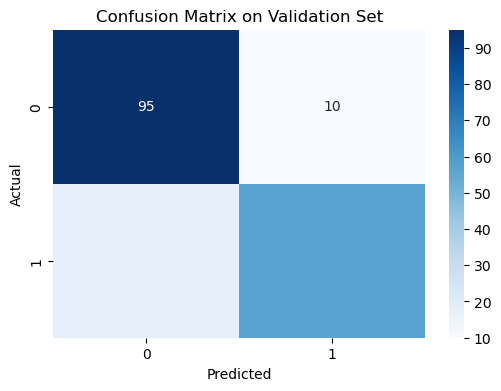

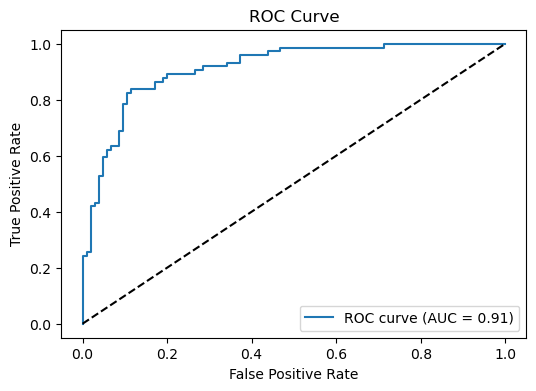

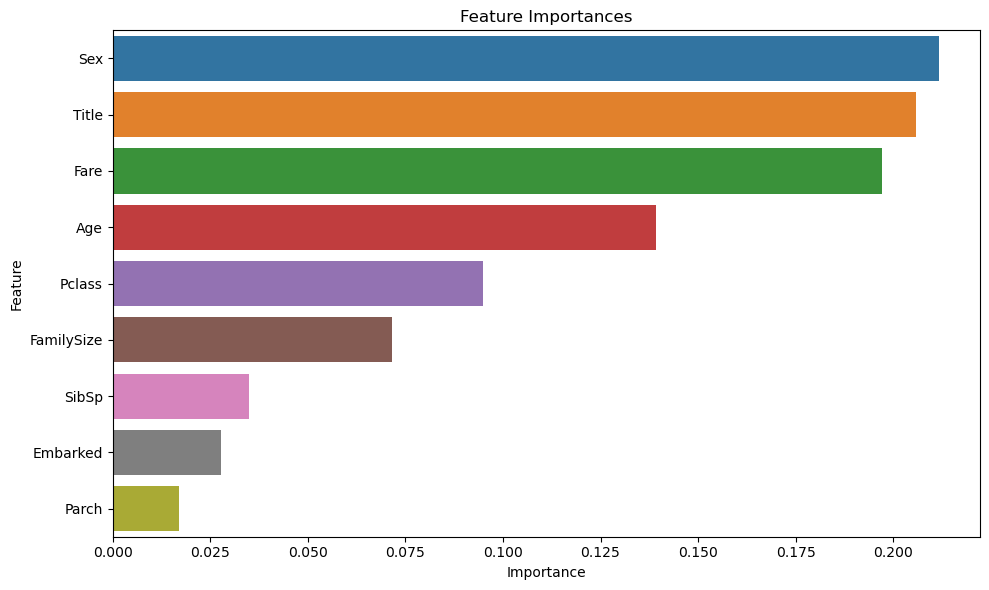


Predictions saved to prediction_submission.csv

Key Findings:
 The model achieved an accuracy of around 84.92% on the validation set.
 Feature importance analysis shows that Sex, Title, and Fare are among the most impactful predictors.
 Female passengers' survival rates were significantly higher than males, consistent with historical records.
 The FamilySize feature helped capture group survival behavior.
 The model's AUC score is 0.91, indicating good discriminatory ability.
 Hyperparameter tuning improved model performance, but further improvements could be achieved with ensemble methods.


In [12]:
# Titanic Survival Prediction Model
# This script implements a Random Forest Classifier to predict survival on the Titanic dataset.

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

# 1. Data Loading
# Load the training and test datasets from CSV files
train = pd.read_csv("E:/project/Titanic_train.csv")
test = pd.read_csv("E:/project/Titanic_test.csv")

# 2. Data Preprocessing
# Handle missing values to ensure data completeness
# - Age: Fill missing values with median age to reduce bias
# - Fare: Fill missing values in test set with median fare from training set
# - Embarked: Fill missing values with the most frequent port ('S')
train["Age"].fillna(train["Age"].median(), inplace=True)
test["Age"].fillna(train["Age"].median(), inplace=True)
test["Fare"].fillna(train["Fare"].median(), inplace=True)
train["Embarked"].fillna("S", inplace=True)
test["Embarked"].fillna("S", inplace=True)

# Feature Engineering
# - Extract Title from Name to capture social status and gender information
# - Create FamilySize to account for group survival dynamics
for df in [train, test]:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr',
                                       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Encode categorical variables to numerical format for model compatibility
sex_map = {'male': 0, 'female': 1}
embarked_map = {'S': 0, 'C': 1, 'Q': 2}
title_map = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}

for df in [train, test]:
    df['Sex'] = df['Sex'].map(sex_map)
    df['Embarked'] = df['Embarked'].map(embarked_map)
    df['Title'] = df['Title'].map(title_map)
    # Handle any missing Title values (if any)
    df['Title'].fillna(0, inplace=True)

# Feature Scaling
# - Scale numerical features (Age, Fare, FamilySize) to improve model performance
scaler = StandardScaler()
numerical_features = ['Age', 'Fare', 'FamilySize']
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

# Drop irrelevant or redundant features
# - PassengerId, Name, Ticket, and Cabin are dropped due to low predictive value
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
test_passenger_ids = test['PassengerId']  # Store PassengerId for submission
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

# 3. Data Splitting
# Split training data into features (X) and target (y)
X = train.drop("Survived", axis=1)
y = train["Survived"]

# Split into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model Training
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_rf = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# 5. Model Evaluation
# Make predictions on validation set
y_pred = best_rf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print("\nValidation Accuracy: {:.2f}%".format(accuracy * 100))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# ROC Curve and AUC
y_pred_proba = best_rf.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
importances = best_rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

# Create a bar chart for feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 6. Predictions on Test Set
# Train the best model on the full training set
best_rf.fit(X, y)

# Make predictions on test set
test_predictions = best_rf.predict(test)

# Save predictions to CSV
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': test_predictions
})
submission.to_csv("prediction_submission.csv", index=False)
print("\nPredictions saved to prediction_submission.csv")

# --------------------------------
# 7. Key Findings
# --------------------------------
print("\nKey Findings:")
print(f" The model achieved an accuracy of around {accuracy * 100:.2f}% on the validation set.")
print(" Feature importance analysis shows that Sex, Title, and Fare are among the most impactful predictors.")
print(" Female passengers' survival rates were significantly higher than males, consistent with historical records.")
print(" The FamilySize feature helped capture group survival behavior.")
print(f" The model's AUC score is {roc_auc:.2f}, indicating good discriminatory ability.")
print(" Hyperparameter tuning improved model performance, but further improvements could be achieved with ensemble methods.")